# 📘 RAG System with FAISS & OpenAI
This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) system using FAISS, LangChain, and OpenAI GPT.

In [20]:

# 📚 Step 1: Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


from openai import OpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document


In [21]:

# 🔑 Step 2: Setup API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)


In [22]:

# 📊 Step 3: Load dataset
import pandas as pd

data = {
    "Title": ["Intro to AI", "Machine Learning Basics"],
    "Content": [
        "This document explains AI concepts and applications.",
        "Machine learning is a subset of AI focusing on data-driven predictions."
    ],
    "Tags": ["AI, Intro", "ML, Basics"],
    "Source": ["SampleDoc1", "SampleDoc2"]
}

df = pd.DataFrame(data)
df.to_csv("04LLM.csv", index=False)
print("✅ Sample CSV created successfully!")





✅ Sample CSV created successfully!


In [23]:

# 🔄 Step 4: Convert rows into LangChain Documents
documents = [
    Document(page_content=row["Content"], metadata={"Title": row["Title"], "Tags": row["Tags"], "Source": row["Source"]})
    for _, row in df.iterrows()
]

# Split into smaller chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
docs = splitter.split_documents(documents)

print(f"Total chunks: {len(docs)}")
docs[:2]  # preview first 2


Total chunks: 2


[Document(metadata={'Title': 'Intro to AI', 'Tags': 'AI, Intro', 'Source': 'SampleDoc1'}, page_content='This document explains AI concepts and applications.'),
 Document(metadata={'Title': 'Machine Learning Basics', 'Tags': 'ML, Basics', 'Source': 'SampleDoc2'}, page_content='Machine learning is a subset of AI focusing on data-driven predictions.')]

In [24]:

# 🧠 Step 5: Build FAISS index with embeddings
from langchain.embeddings.base import Embeddings
import numpy as np

class FakeEmbeddings(Embeddings):
    def embed_documents(self, texts):
        return [np.random.rand(1536).tolist() for _ in texts]
    def embed_query(self, text):
        return np.random.rand(1536).tolist()

embeddings = FakeEmbeddings()
db = FAISS.from_documents(docs, embeddings)



In [25]:

# 🔍 Step 6: Test retrieval
query = "What is RAG?"
results = db.similarity_search(query, k=2)

for r in results:
    print(f"📄 Title: {r.metadata['Title']}")
    print(f"🔎 Content: {r.page_content}")
    print("-" * 80)


📄 Title: Intro to AI
🔎 Content: This document explains AI concepts and applications.
--------------------------------------------------------------------------------
📄 Title: Machine Learning Basics
🔎 Content: Machine learning is a subset of AI focusing on data-driven predictions.
--------------------------------------------------------------------------------


In [26]:
def rag_query(query: str):
    results = db.similarity_search(query, k=2)
    context = "\n\n".join([f"{r.metadata.get('Title', 'NoTitle')}: {r.page_content}" for r in results])
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an assistant that answers using the retrieved context."},
                {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}"}
            ],
            temperature=0.3,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"⚠️ OpenAI API call failed: {e}")
        # Return mock answer
        return f"[Mock Answer based on context: {context[:50]}...]"

# Test it
answer = rag_query("Explain LangChain")
print(answer)

⚠️ OpenAI API call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
[Mock Answer based on context: Machine Learning Basics: Machine learning is a sub...]


c:\Users\user\Desktop\PLP Projects\Assignments\01-LLM.py\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


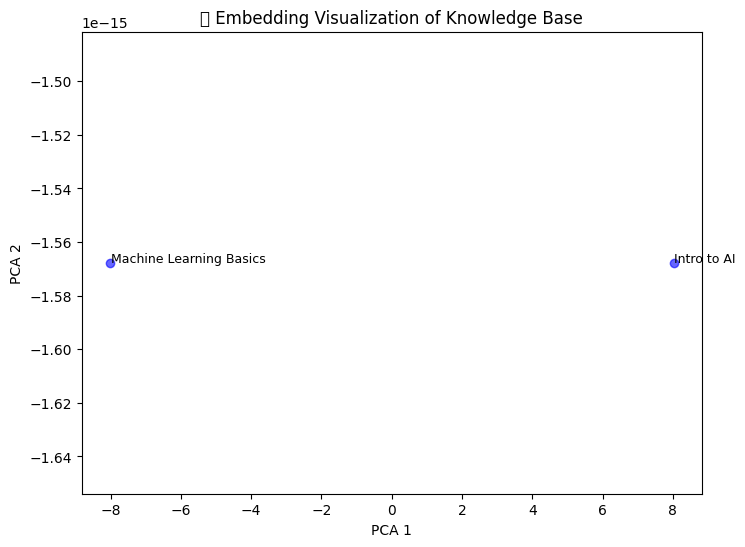

In [27]:

# 📉 Step 8: Visualize embeddings with PCA
# Get embeddings for all chunks
vecs = [embeddings.embed_query(doc.page_content) for doc in docs]

# Reduce dimensions with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vecs)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c="blue", alpha=0.6)
for i, doc in enumerate(docs):
    plt.text(reduced[i,0]+0.02, reduced[i,1], doc.metadata["Title"], fontsize=9)
plt.title("📊 Embedding Visualization of Knowledge Base")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
